## Importing Packages

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section the required packages are imported, and briefly discuss, the libraries that will be used throughout the analysis and modelling. |

In [98]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

## Loading Data

---

In this section you are required to load data from local and then extract it to the storage directory.

---

In [2]:
df = pd.read_csv('traveloka_clean.csv')

In [3]:
df.head()

,content,score,sentiment,clean_content
0,kenapa kalau mau melakukan pembayaran harganya...,1,negative,kalau laku bayar harga jadi ubah harga awal ha...
1,Salah satu fitur terbaik adalah informasi posi...,5,positive,salah satu fitur baik informasi posisi realtim...
2,"kok traveloka skrg jd aneh, tiba2 saja limit t...",1,negative,traveloka skrg aneh tiba limit tpaylaternya gu...
3,menginap di hotel o surabaya bayar by aplikasi...,1,negative,inap hotel surabaya bayar aplikasi trevelokaud...
4,saya mau pesan tiket kereta dari jember ke jak...,3,neutral,pesan tiket kereta jember jakarta penuh semua ...


## visualization Distribution

---

Create data distribution visualizations to understand the distribution of sentiment classes (positive, negative, neutral) in the dataset. This analysis is crucial for identifying potential class imbalance and planning appropriate modeling strategies.

---

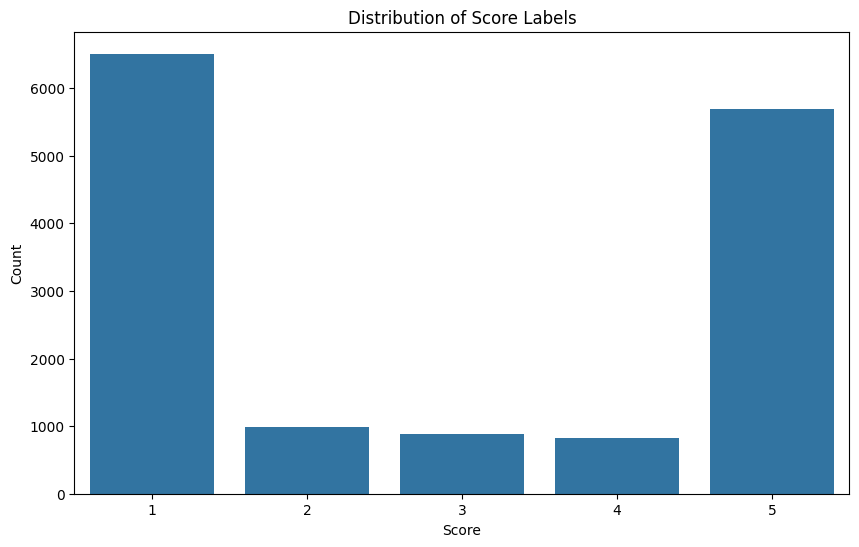

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df)
plt.title('Distribution of Score Labels')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

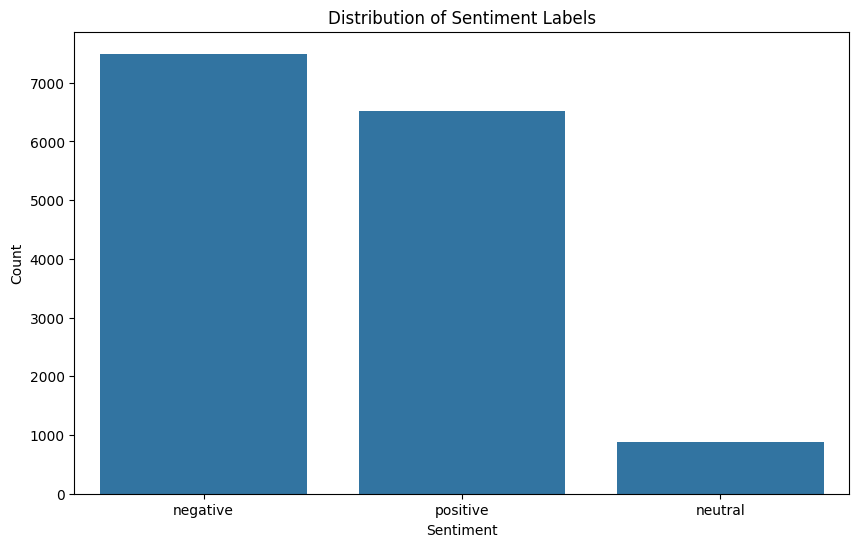

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Feature Engineering

### TF-IDF Vectorizer

---

Implement Term Frequency-Inverse Document Frequency (TF-IDF) to convert text into numerical representations. TF-IDF assigns higher weights to words that are rare but important in the context of specific documents.

---

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.75,
    lowercase=True,
    stop_words=None
)

In [7]:
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_content'])
y = df['sentiment']

In [8]:
print(f"\nTF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of features created: {len(tfidf_vectorizer.get_feature_names_out())}")


TF-IDF matrix shape: (14894, 1000)
Number of features created: 1000


In [9]:
# Display some sample features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features (first 20):")
for i, feature in enumerate(feature_names[:20]):
    print(f"{i+1:2d}. {feature}")

print(f"\nSample features (last 20):")
for i, feature in enumerate(feature_names[-20:]):
    print(f"{len(feature_names)-19+i:2d}. {feature}")


Sample features (first 20):
 1. abis
 2. ada
 3. admin
 4. agen
 5. aju
 6. aju paylater
 7. aju refund
 8. akal
 9. akhir
10. akibat
11. akomodasi
12. akses
13. aktif
14. aktivitas
15. akun
16. akun paylater
17. alam
18. alamat
19. alami
20. alas

Sample features (last 20):
981. untung
982. update
983. upgrade
984. upload
985. urus
986. usah
987. usaha
988. user
989. utama
990. verifikasi
991. versi
992. versi baru
993. virtual
994. virtual number
995. voucher
996. wajib
997. waktu
998. walaupun
999. wifi
1000. wisata


#### Label Encoder for Sentiment

In [10]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
print(f"\n=== TARGET VARIABLE ENCODING ===")
print("Label mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")


=== TARGET VARIABLE ENCODING ===
Label mapping:
negative -> 0
neutral -> 1
positive -> 2


#### Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
    )

In [13]:
print(f"\n=== DATA SPLITTING ===")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


=== DATA SPLITTING ===
Training set shape: (11915, 1000)
Testing set shape: (2979, 1000)
Training labels shape: (11915,)
Testing labels shape: (2979,)


In [14]:
# Display class distribution in train and test sets
print(f"\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique, counts):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count} ({count/len(y_train)*100:.1f}%)")


Training set class distribution:
negative: 5994 (50.3%)
neutral: 711 (6.0%)
positive: 5210 (43.7%)


In [15]:
print(f"\nTesting set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for class_idx, count in zip(unique, counts):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count} ({count/len(y_test)*100:.1f}%)")


Testing set class distribution:
negative: 1499 (50.3%)
neutral: 177 (5.9%)
positive: 1303 (43.7%)


### Handling Imbalanced Data

---

Address data imbalance using techniques such as SMOTE (Synthetic Minority Oversampling Technique), undersampling, or class weighting to ensure the model can predict all classes effectively.

---

### Check Class Distribution

---

Analyze the distribution of sentiment classes in the dataset to identify the severity of class imbalance. This step visualizes the count of samples for each class and calculates the imbalance ratio to determine appropriate resampling strategies.

---

In [16]:
print("Original class distributiin: ")
original_distribution = Counter(y_train)
for class_idx, count in original_distribution.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count} ({count/len(y_train)*100:.1f}%)")


Original class distributiin: 
positive: 5210 (43.7%)
negative: 5994 (50.3%)
neutral: 711 (6.0%)


In [17]:
# calculate imbalanced ratio
max_count = max(original_distribution.values())
min_count = min(original_distribution.values())
imbalanced_ratio = max_count / min_count
print(f"\nImbalanced ratio: {imbalanced_ratio:.2f}:1")


Imbalanced ratio: 8.43:1


### SMOTE

---

Apply Synthetic Minority Oversampling Technique (SMOTE) to generate synthetic samples for minority classes. SMOTE creates new instances by interpolating between existing minority class samples, effectively balancing the dataset without simply duplicating existing data points.

---

In [18]:
# initialize SMOTE
smote = SMOTE(
    sampling_strategy='auto',
    random_state=42,
    k_neighbors=5,
)

In [19]:
# applying SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [20]:
print(f"\nResampling completed!")
print(f"Original training shape: {X_train.shape}")
print(f"Balanced training shape: {X_train_smote.shape}")


Resampling completed!
Original training shape: (11915, 1000)
Balanced training shape: (17982, 1000)


In [21]:
# Check new class distribution
print(f"\nBalanced class distribution:")
balanced_distribution = Counter(y_train_smote)
for class_idx, count in balanced_distribution.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count} ({count/len(y_train_smote)*100:.1f}%)")


Balanced class distribution:
positive: 5994 (33.3%)
negative: 5994 (33.3%)
neutral: 5994 (33.3%)


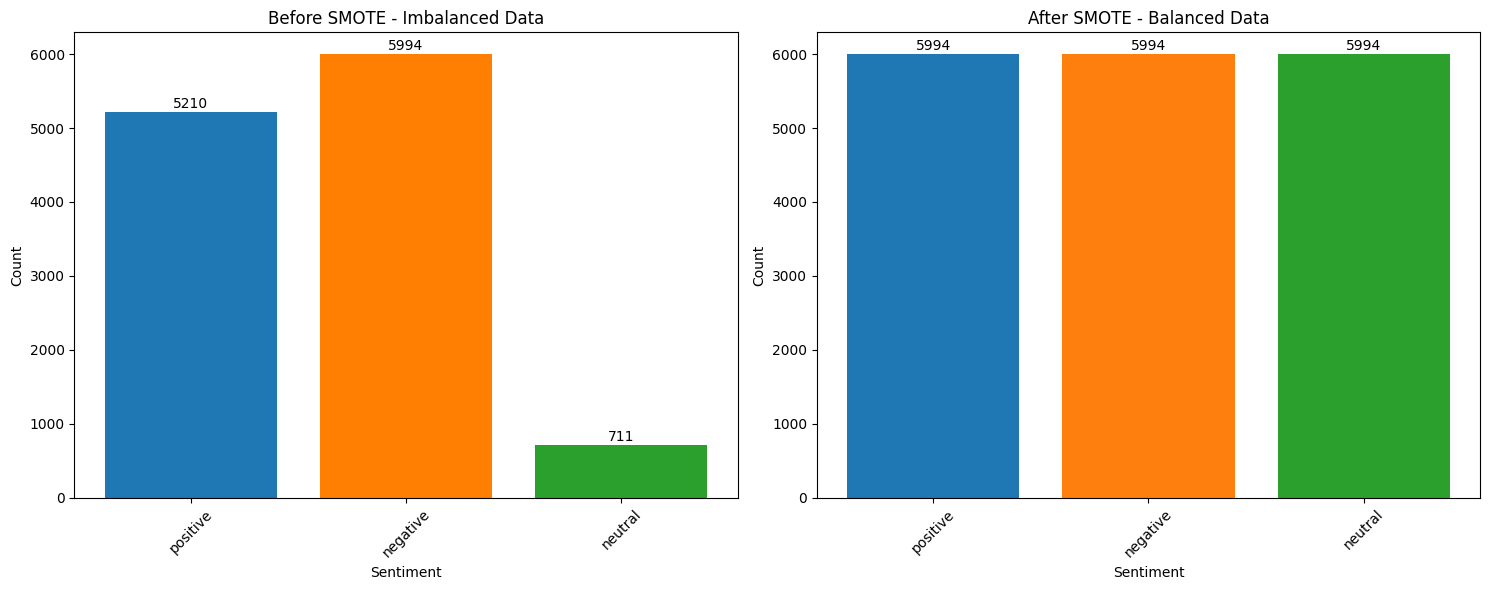

In [22]:
# visualize before and after balance
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
# before SMOTE
original_labels = [label_encoder.inverse_transform([idx])[0] for idx in original_distribution.keys()]
original_counts = list(original_distribution.values())

ax1.bar(original_labels, original_counts, color=['#1f77b4', '#ff7f03', '#2ca02c'])
ax1.set_title('Before SMOTE - Imbalanced Data')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# add count labels on bars
for i, count in enumerate(original_counts):
  ax1.text(i, count + max(original_counts)*0.01, str(count), ha='center')

# after SMOTE
balanced_labels = [label_encoder.inverse_transform([idx])[0] for idx in balanced_distribution.keys()]
balanced_counts = list(balanced_distribution.values())

ax2.bar(balanced_labels, balanced_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('After SMOTE - Balanced Data')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# add count labels on bars
for i, count in enumerate(balanced_counts):
  ax2.text(i, count + max(balanced_counts)*0.01, str(count), ha='center')

plt.tight_layout()
plt.show()

### SMOTETomek

---

Implement SMOTETomek, a hybrid approach that combines SMOTE oversampling with Tomek links undersampling. This technique first applies SMOTE to increase minority class samples, then removes Tomek links (pairs of samples from different classes that are each other's nearest neighbors) to clean overlapping regions and improve class separation.

---

In [23]:
smote_tomek = SMOTETomek(
    sampling_strategy='auto',
    random_state=42,
    smote=SMOTE(k_neighbors=5, random_state=42)
)

In [24]:
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train, y_train)

In [25]:
print(f"\nSMOTETomek results:")
print(f"Original training shape: {X_train.shape}")
print(f"SMOTETomek training shape: {X_train_smotetomek.shape}")


SMOTETomek results:
Original training shape: (11915, 1000)
SMOTETomek training shape: (17830, 1000)


In [26]:
smotetomek_distribution = Counter(y_train_smotetomek)
print(f"\nSMOTETomek class distribution:")
for class_idx, count in smotetomek_distribution.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name}: {count} ({count/len(y_train_smotetomek)*100:.1f}%)")


SMOTETomek class distribution:
positive: 5918 (33.2%)
negative: 5918 (33.2%)
neutral: 5994 (33.6%)


### Initialize final train data

---

Prepare the final balanced training dataset by selecting the best resampling technique based on evaluation metrics. This step finalizes the data preprocessing pipeline and creates the optimized dataset for model training.

---

In [27]:
X_train_final = X_train_smote
y_train_final = y_train_smote

In [28]:
print("=== MODEL IMPLEMENTATION ===")
print(f"Training data shape: {X_train_final.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training started at: {datetime.now().strftime('%H:%M:%S')}")

=== MODEL IMPLEMENTATION ===
Training data shape: (17982, 1000)
Test data shape: (2979, 1000)
Training started at: 09:10:10


In [29]:
models = {}
results = {}

## Model Implementation

---

Implement various machine learning algorithms for sentiment classification, including traditional models such as Random Forest, Naive Bayes, SVM, and Logistic Regression.

---

### Random Forest

---

Implement Random Forest classifier, an ensemble method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. This algorithm is particularly effective for text classification as it can handle high-dimensional sparse data and provides feature importance rankings.

---

In [30]:
rf_start = datetime.now()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

In [31]:
rf_model.fit(X_train_final, y_train_final)
rf_pred = rf_model.predict(X_test)
rf_time = (datetime.now() - rf_start).total_seconds()

In [32]:
models['Random Forest'] = rf_model
results['Random Forest'] = {
    'predictions': rf_pred,
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_recall_fscore_support(y_test, rf_pred),
    'training_time': rf_time,
}

In [33]:
print(f"✓ Random Forest completed in {rf_time:.2f} seconds")
print(f"  Accuracy: {results['Random Forest']['accuracy']:.4f}")

✓ Random Forest completed in 2.77 seconds
  Accuracy: 0.7865


### SVC

---

Deploy Support Vector Classifier for sentiment classification. SVC finds the optimal hyperplane that separates different sentiment classes with maximum margin, making it robust for high-dimensional text data and effective in handling non-linearly separable data through kernel methods.

---

In [34]:
svc_start = datetime.now()
svc_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    random_state=42,
)

In [35]:
svc_model.fit(X_train_final, y_train_final)
svc_pred = svc_model.predict(X_test)
svc_time = (datetime.now() - svc_start).total_seconds()

In [36]:
models['SVC'] = svc_model
results['SVC'] = {
    'predictions': svc_pred,
    'accuracy': accuracy_score(y_test, svc_pred),
    'precision': precision_recall_fscore_support(y_test, svc_pred),
    'training_time': svc_time,
}

In [37]:
print(f"✓ SVC completed in {svc_time:.2f} seconds")
print(f"  Accuracy: {results['SVC']['accuracy']:.4f}")

✓ SVC completed in 47.29 seconds
  Accuracy: 0.8513


### Naive Bayes

---

Implement Naive Bayes classifier, a probabilistic algorithm that applies Bayes' theorem with strong independence assumptions between features. This model is particularly suitable for text classification tasks due to its effectiveness with sparse data and computational efficiency.

---

In [38]:
nb_start = datetime.now()
nb_model = MultinomialNB(
    alpha=1.0,
    fit_prior=True,
)

In [39]:
nb_model.fit(X_train_final, y_train_final)
nb_pred = nb_model.predict(X_test)
nb_time = (datetime.now() - nb_start).total_seconds()

In [40]:
models['Naive Bayes'] = nb_model
results['Naive Bayes'] = {
    'predictions': nb_pred,
    'accuracy': accuracy_score(y_test, nb_pred),
    'precision': precision_recall_fscore_support(y_test, nb_pred),
    'training_time': nb_time,
}

In [41]:
print(f"✓ Naive Bayes completed in {nb_time:.2f} seconds")
print(f"  Accuracy: {results['Naive Bayes']['accuracy']:.4f}")

✓ Naive Bayes completed in 0.01 seconds
  Accuracy: 0.7362


### Logistic Regression

---

Apply Logistic Regression for multi-class sentiment classification. This linear model uses the logistic function to model the probability of class membership and provides interpretable coefficients that can help understand which features contribute most to sentiment predictions.

---

In [42]:
lr_start = datetime.now()
lr_model = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42,
    class_weight='balanced',
    C=1.0
)

In [43]:
lr_model.fit(X_train_final, y_train_final)
lr_pred = lr_model.predict(X_test)
lr_time = (datetime.now() - lr_start).total_seconds()

In [44]:
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'predictions': lr_pred,
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_recall_fscore_support(y_test, lr_pred),
    'training_time': lr_time,
}

In [45]:
print(f"✓ Logistic Regression completed in {lr_time:.2f} seconds")
print(f"  Accuracy: {results['Logistic Regression']['accuracy']:.4f}")

✓ Logistic Regression completed in 0.18 seconds
  Accuracy: 0.7664


## Summary of All Models

---

Create a performance summary of all trained models, displaying evaluation metrics such as accuracy, precision, recall, and F1-score for each model. This analysis helps in selecting the best performing model.

---

In [46]:
summary_data = []
for model_name, result in results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'][0],
        'Recall': result['precision'][1],
        'F1-Score': result['precision'][2],
        'Support': result['precision'][3],
        'Training Time (s)': result['training_time'],
    })

In [47]:
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Accuracy', ascending=False)

In [48]:
print(summary_df.to_string(index=False, float_format='%.4f'))

              Model  Accuracy                                                     Precision                                                         Recall                                                      F1-Score           Support  Training Time (s)
                SVC    0.8513  [0.8151549942594719, 0.3333333333333333, 0.9049553208773355] [0.9472981987991995, 0.011299435028248588, 0.8549501151189562] [0.8762727553224313, 0.02185792349726776, 0.8792423046566693] [1499, 177, 1303]            47.2931
      Random Forest    0.7865 [0.8343771746694503, 0.19230769230769232, 0.8402140672782875]    [0.799866577718479, 0.2542372881355932, 0.8434382194934766] [0.8167574931880109, 0.21897810218978103, 0.8418230563002681] [1499, 177, 1303]             2.7748
Logistic Regression    0.7664 [0.8757911392405063, 0.15717092337917485, 0.9087893864013267]   [0.7384923282188125, 0.4519774011299435, 0.8411358403683806] [0.8013029315960912, 0.23323615160349853, 0.8736548425667596] [1499, 177, 1303]    

### Visualize model Comparison

---

Create visualizations comparing model performance using bar charts, confusion matrix heatmaps, or ROC curves to provide clear insights into the strengths and weaknesses of each model.

---

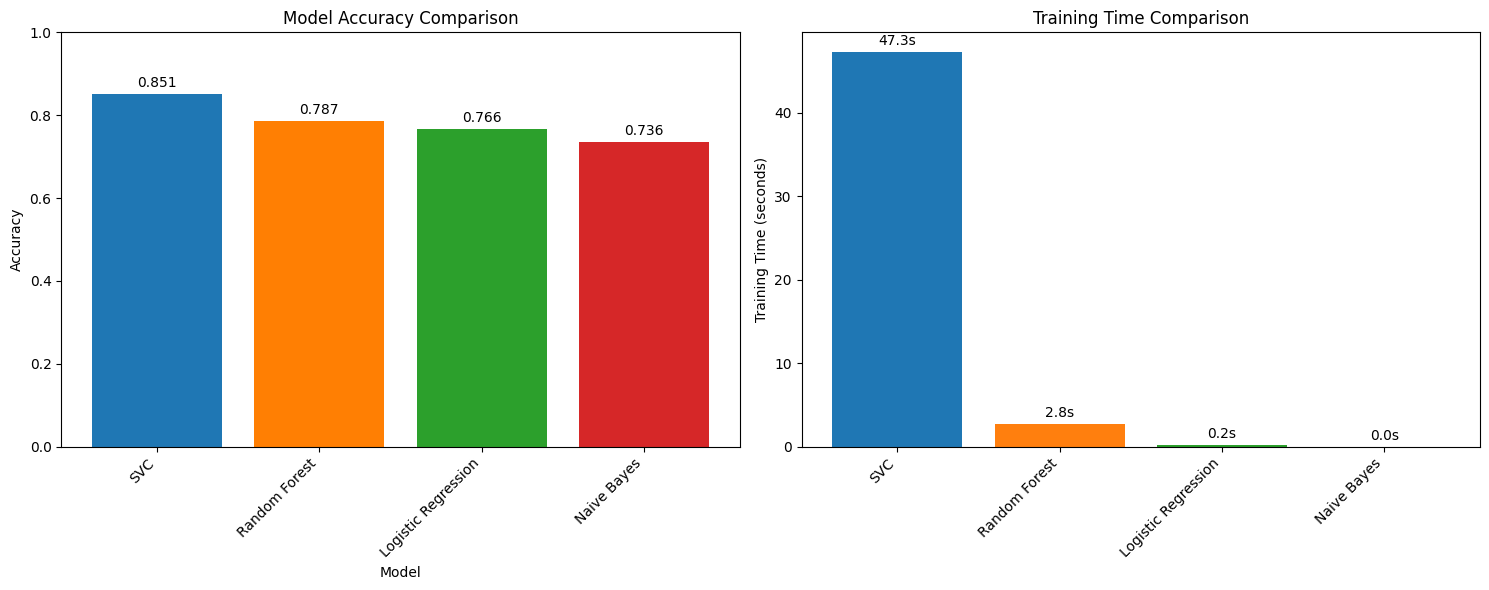

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# accuracy comparison
ax1.bar(summary_df['Model'], summary_df['Accuracy'],
        color=['#1f77b4', '#ff7f03', '#2ca02c', '#d62728'])
ax1.set_title('Model Accuracy Comparison')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# add accuracy values on bars
for i, v in enumerate(summary_df['Accuracy']):
  ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Training time comparison
ax2.bar(summary_df['Model'], summary_df['Training Time (s)'],
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_title('Training Time Comparison')
ax2.set_ylabel('Training Time (seconds)')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# add time values on bars
for i, v in enumerate(summary_df['Training Time (s)']):
  ax2.text(i, v + max(summary_df['Training Time (s)']) * 0.01, f'{v:.1f}s',
           ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [50]:
# Best model identification
best_model = summary_df.iloc[0]['Model']
best_accuracy = summary_df.iloc[0]['Accuracy']
print(f"\n🏆 Best performing model: {best_model} (Accuracy: {best_accuracy:.4f})")


🏆 Best performing model: SVC (Accuracy: 0.8513)


## Model Evaluation

---

Conduct in-depth evaluation of selected models using various evaluation metrics and validation techniques such as cross-validation to ensure model robustness and generalization.

---

In [51]:
class_names = label_encoder.classes_
n_classes = len(class_names)

In [52]:
print(f"Classes: {class_names}")
print(f"Number of classes: {n_classes}")

Classes: ['negative' 'neutral' 'positive']
Number of classes: 3


In [53]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names)
  plt.title(f'Confusion Matrix - {model_name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.tight_layout()
  plt.show()

  return cm

In [54]:
detailed_results = {}


DETAILED EVALUATION: RANDOM FOREST
Accuracy: 0.7865
Training Time: 2.77 seconds

Classification Report:
              precision    recall  f1-score   support

    negative     0.8344    0.7999    0.8168      1499
     neutral     0.1923    0.2542    0.2190       177
    positive     0.8402    0.8434    0.8418      1303

    accuracy                         0.7865      2979
   macro avg     0.6223    0.6325    0.6259      2979
weighted avg     0.7988    0.7865    0.7922      2979


Confusion Matrix:


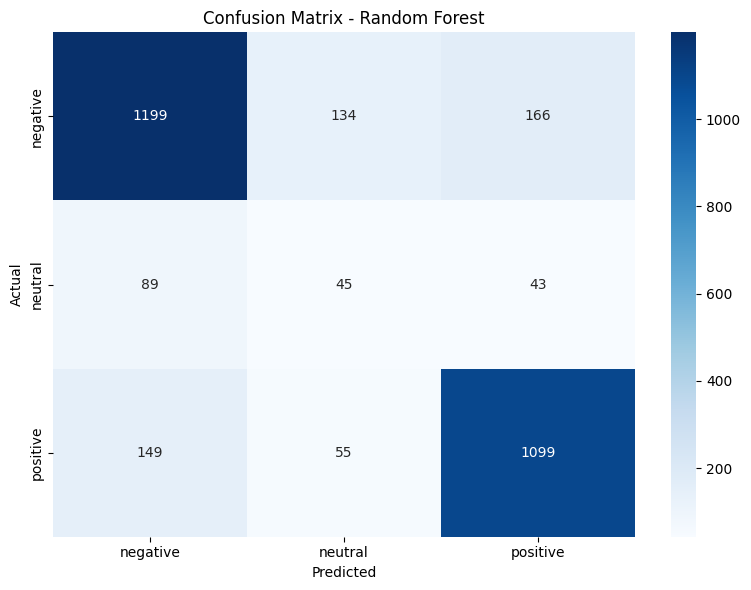


Per-Class Metrics:
  negative: Precision=0.8344, Recall=0.7999, F1=0.8168, Support=1499
   neutral: Precision=0.1923, Recall=0.2542, F1=0.2190, Support=177
  positive: Precision=0.8402, Recall=0.8434, F1=0.8418, Support=1303

Macro Average:    Precision=0.6223, Recall=0.6325, F1=0.6259
Weighted Average: Precision=0.7988, Recall=0.7865, F1=0.7922

DETAILED EVALUATION: SVC
Accuracy: 0.8513
Training Time: 47.29 seconds

Classification Report:
              precision    recall  f1-score   support

    negative     0.8152    0.9473    0.8763      1499
     neutral     0.3333    0.0113    0.0219       177
    positive     0.9050    0.8550    0.8792      1303

    accuracy                         0.8513      2979
   macro avg     0.6845    0.6045    0.5925      2979
weighted avg     0.8258    0.8513    0.8268      2979


Confusion Matrix:


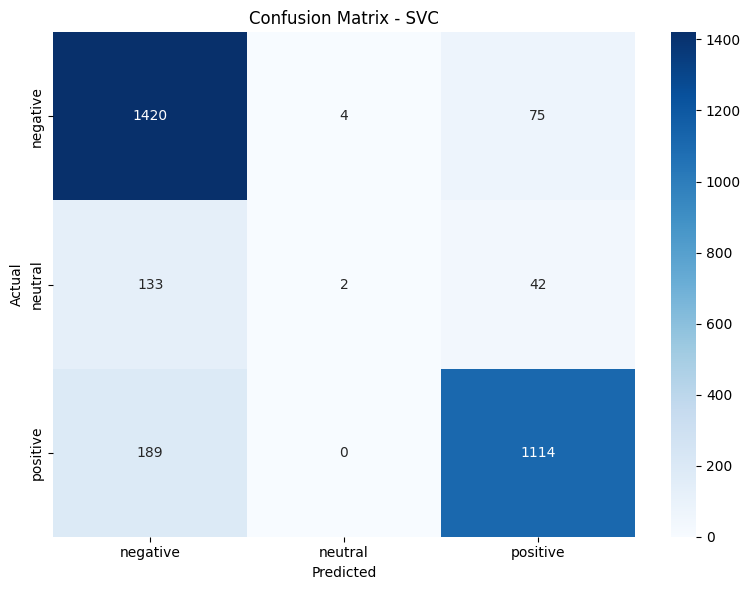


Per-Class Metrics:
  negative: Precision=0.8152, Recall=0.9473, F1=0.8763, Support=1499
   neutral: Precision=0.3333, Recall=0.0113, F1=0.0219, Support=177
  positive: Precision=0.9050, Recall=0.8550, F1=0.8792, Support=1303

Macro Average:    Precision=0.6845, Recall=0.6045, F1=0.5925
Weighted Average: Precision=0.8258, Recall=0.8513, F1=0.8268

DETAILED EVALUATION: NAIVE BAYES
Accuracy: 0.7362
Training Time: 0.01 seconds

Classification Report:
              precision    recall  f1-score   support

    negative     0.8646    0.6985    0.7727      1499
     neutral     0.1526    0.5537    0.2393       177
    positive     0.9307    0.8043    0.8629      1303

    accuracy                         0.7362      2979
   macro avg     0.6493    0.6855    0.6250      2979
weighted avg     0.8512    0.7362    0.7805      2979


Confusion Matrix:


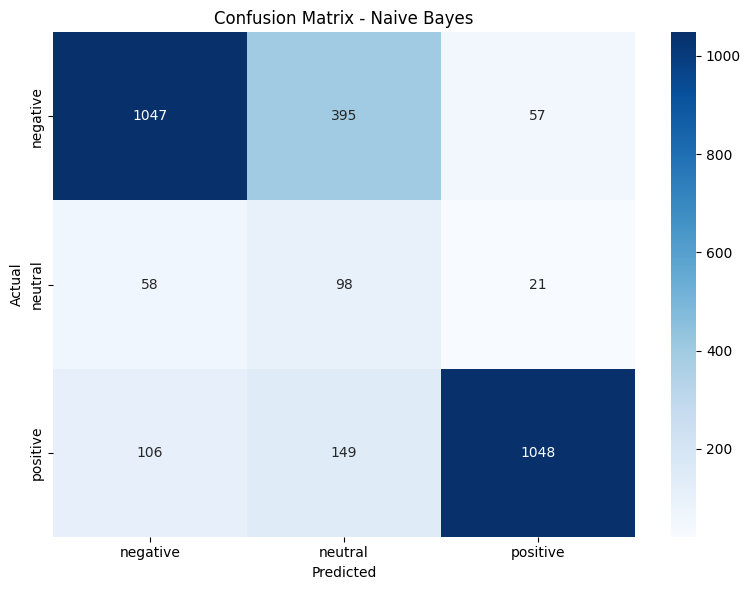


Per-Class Metrics:
  negative: Precision=0.8646, Recall=0.6985, F1=0.7727, Support=1499
   neutral: Precision=0.1526, Recall=0.5537, F1=0.2393, Support=177
  positive: Precision=0.9307, Recall=0.8043, F1=0.8629, Support=1303

Macro Average:    Precision=0.6493, Recall=0.6855, F1=0.6250
Weighted Average: Precision=0.8512, Recall=0.7362, F1=0.7805

DETAILED EVALUATION: LOGISTIC REGRESSION
Accuracy: 0.7664
Training Time: 0.18 seconds

Classification Report:
              precision    recall  f1-score   support

    negative     0.8758    0.7385    0.8013      1499
     neutral     0.1572    0.4520    0.2332       177
    positive     0.9088    0.8411    0.8737      1303

    accuracy                         0.7664      2979
   macro avg     0.6473    0.6772    0.6361      2979
weighted avg     0.8475    0.7664    0.7992      2979


Confusion Matrix:


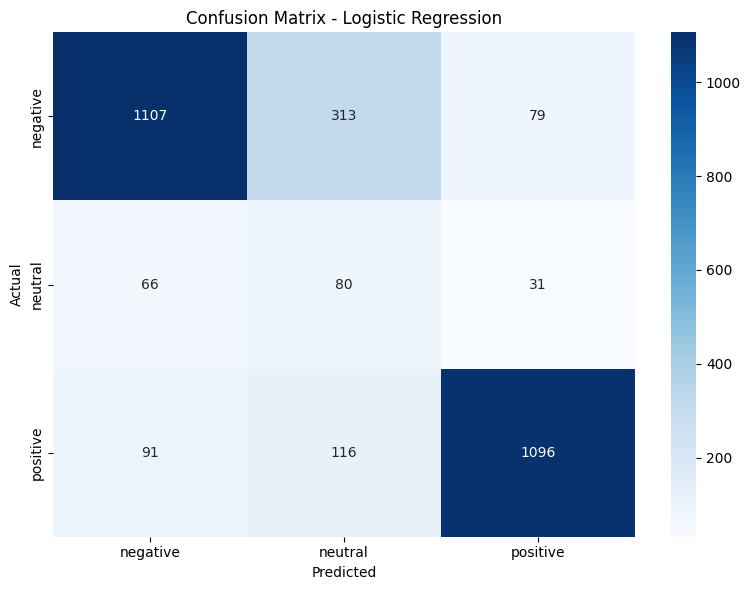


Per-Class Metrics:
  negative: Precision=0.8758, Recall=0.7385, F1=0.8013, Support=1499
   neutral: Precision=0.1572, Recall=0.4520, F1=0.2332, Support=177
  positive: Precision=0.9088, Recall=0.8411, F1=0.8737, Support=1303

Macro Average:    Precision=0.6473, Recall=0.6772, F1=0.6361
Weighted Average: Precision=0.8475, Recall=0.7664, F1=0.7992


In [55]:
for model_name, result in results.items():
    print(f"\n{'='*70}")
    print(f"DETAILED EVALUATION: {model_name.upper()}")
    print(f"{'='*70}")

    y_pred = result['predictions']

    # basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training Time: {result['training_time']:.2f} seconds")

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    # confusion matrix
    print(f"\nConfusion Matrix:")
    cm = plot_confusion_matrix(y_test, y_pred, model_name, class_names)

    # per-class metrics
    print(f"\nPer-Class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name:>10}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}, Support={support[i]}")

    # Macro and weighted averages
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)

    precision_weighted = np.average(precision, weights=support)
    recall_weighted = np.average(recall, weights=support)
    f1_weighted = np.average(f1, weights=support)

    print(f"\nMacro Average:    Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1={f1_macro:.4f}")
    print(f"Weighted Average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1={f1_weighted:.4f}")

    # Store detailed results
    detailed_results[model_name] = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'support': support
    }

### Comprehensive Comparison Table

In [56]:
comparison_data = []
for model_name, metrics in detailed_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision (Macro)': metrics['precision_macro'],
        'Recall (Macro)': metrics['recall_macro'],
        'F1 (Macro)': metrics['f1_macro'],
        'Precision (Weighted)': metrics['precision_weighted'],
        'Recall (Weighted)': metrics['recall_weighted'],
        'F1 (Weighted)': metrics['f1_weighted'],
        'Training Time (s)': results[model_name]['training_time']
    })

In [57]:
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print(comparison_df.to_string(index=False, float_format='%.4f'))

              Model  Accuracy  Precision (Macro)  Recall (Macro)  F1 (Macro)  Precision (Weighted)  Recall (Weighted)  F1 (Weighted)  Training Time (s)
                SVC    0.8513             0.6845          0.6045      0.5925                0.8258             0.8513         0.8268            47.2931
      Random Forest    0.7865             0.6223          0.6325      0.6259                0.7988             0.7865         0.7922             2.7748
Logistic Regression    0.7664             0.6473          0.6772      0.6361                0.8475             0.7664         0.7992             0.1820
        Naive Bayes    0.7362             0.6493          0.6855      0.6250                0.8512             0.7362         0.7805             0.0111


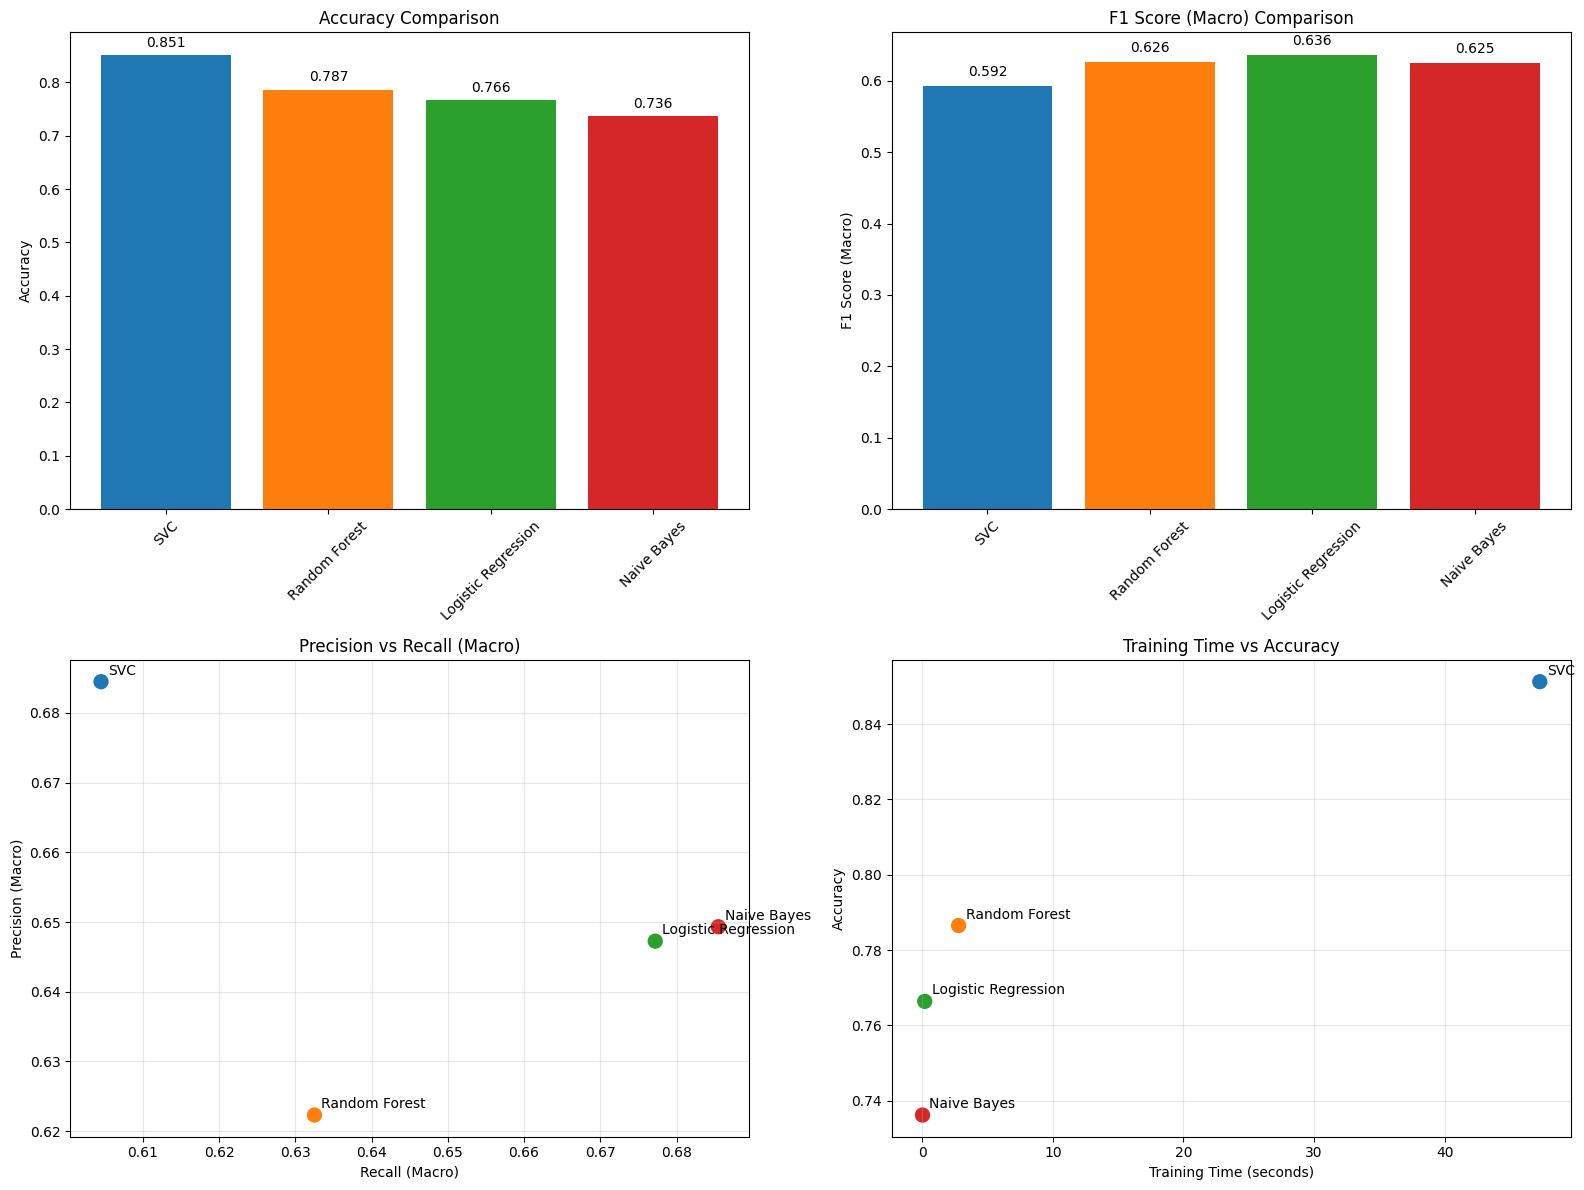

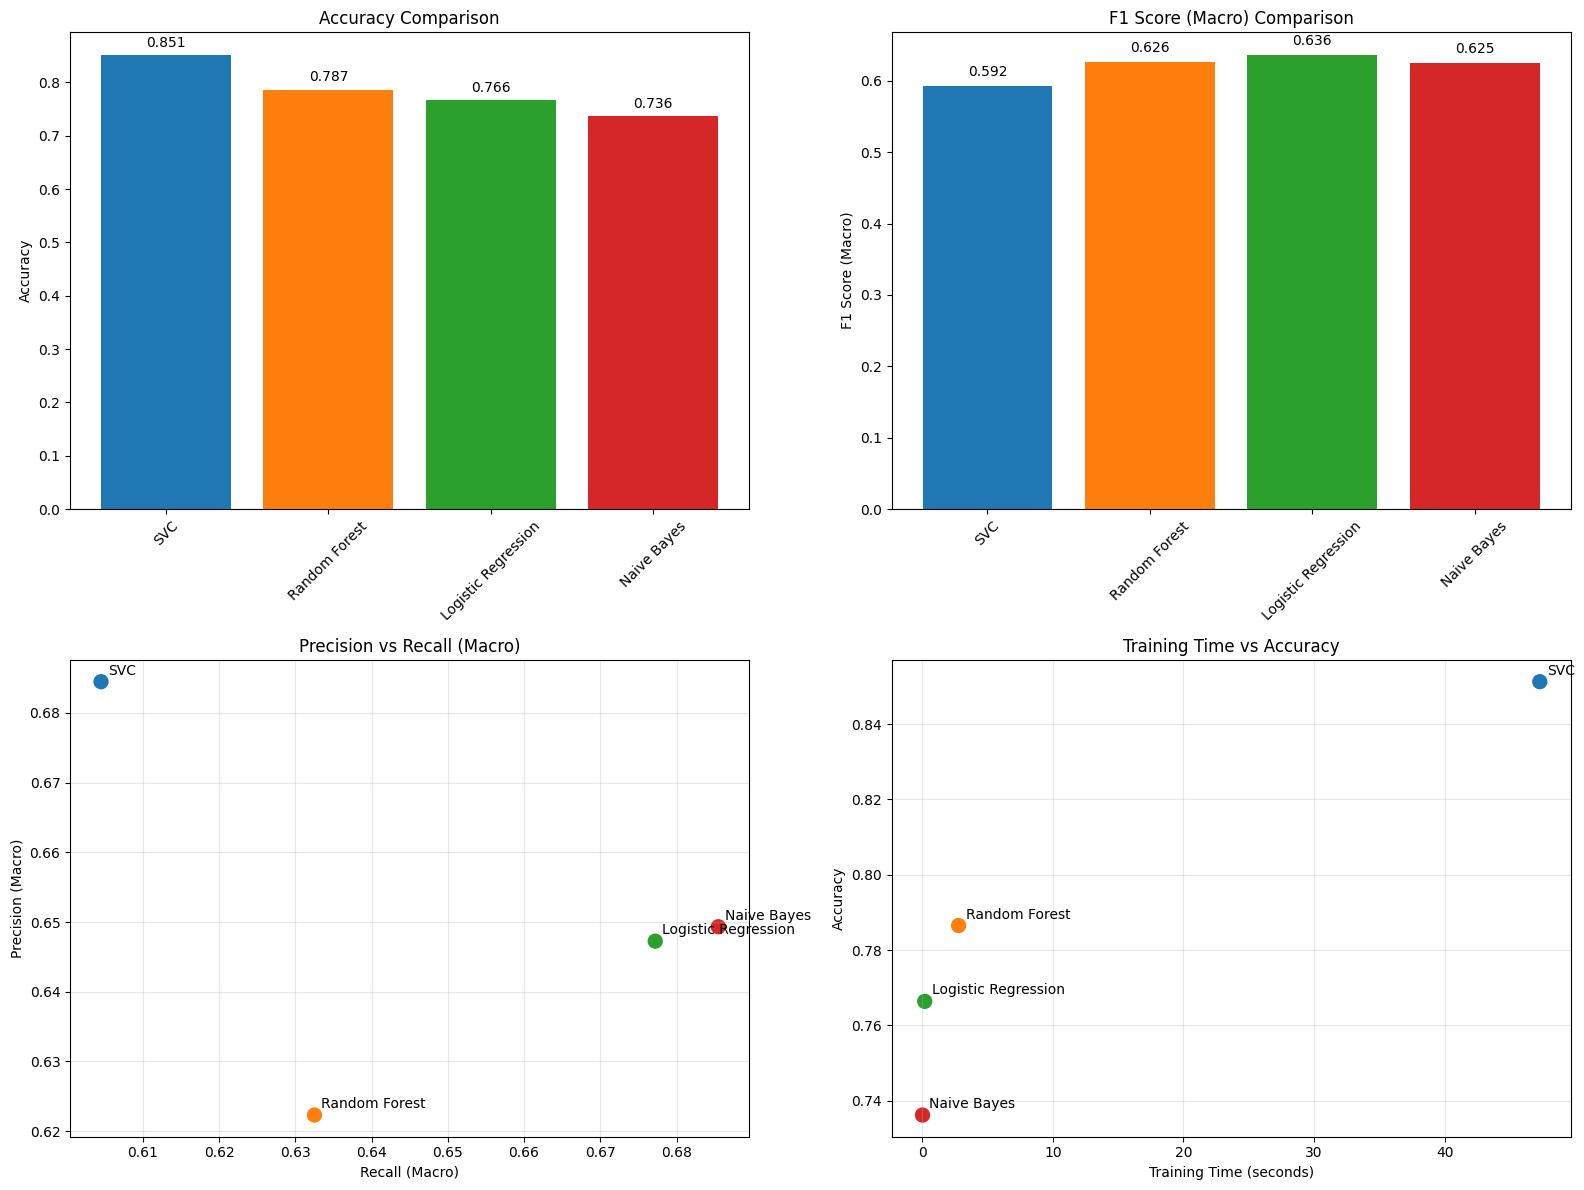

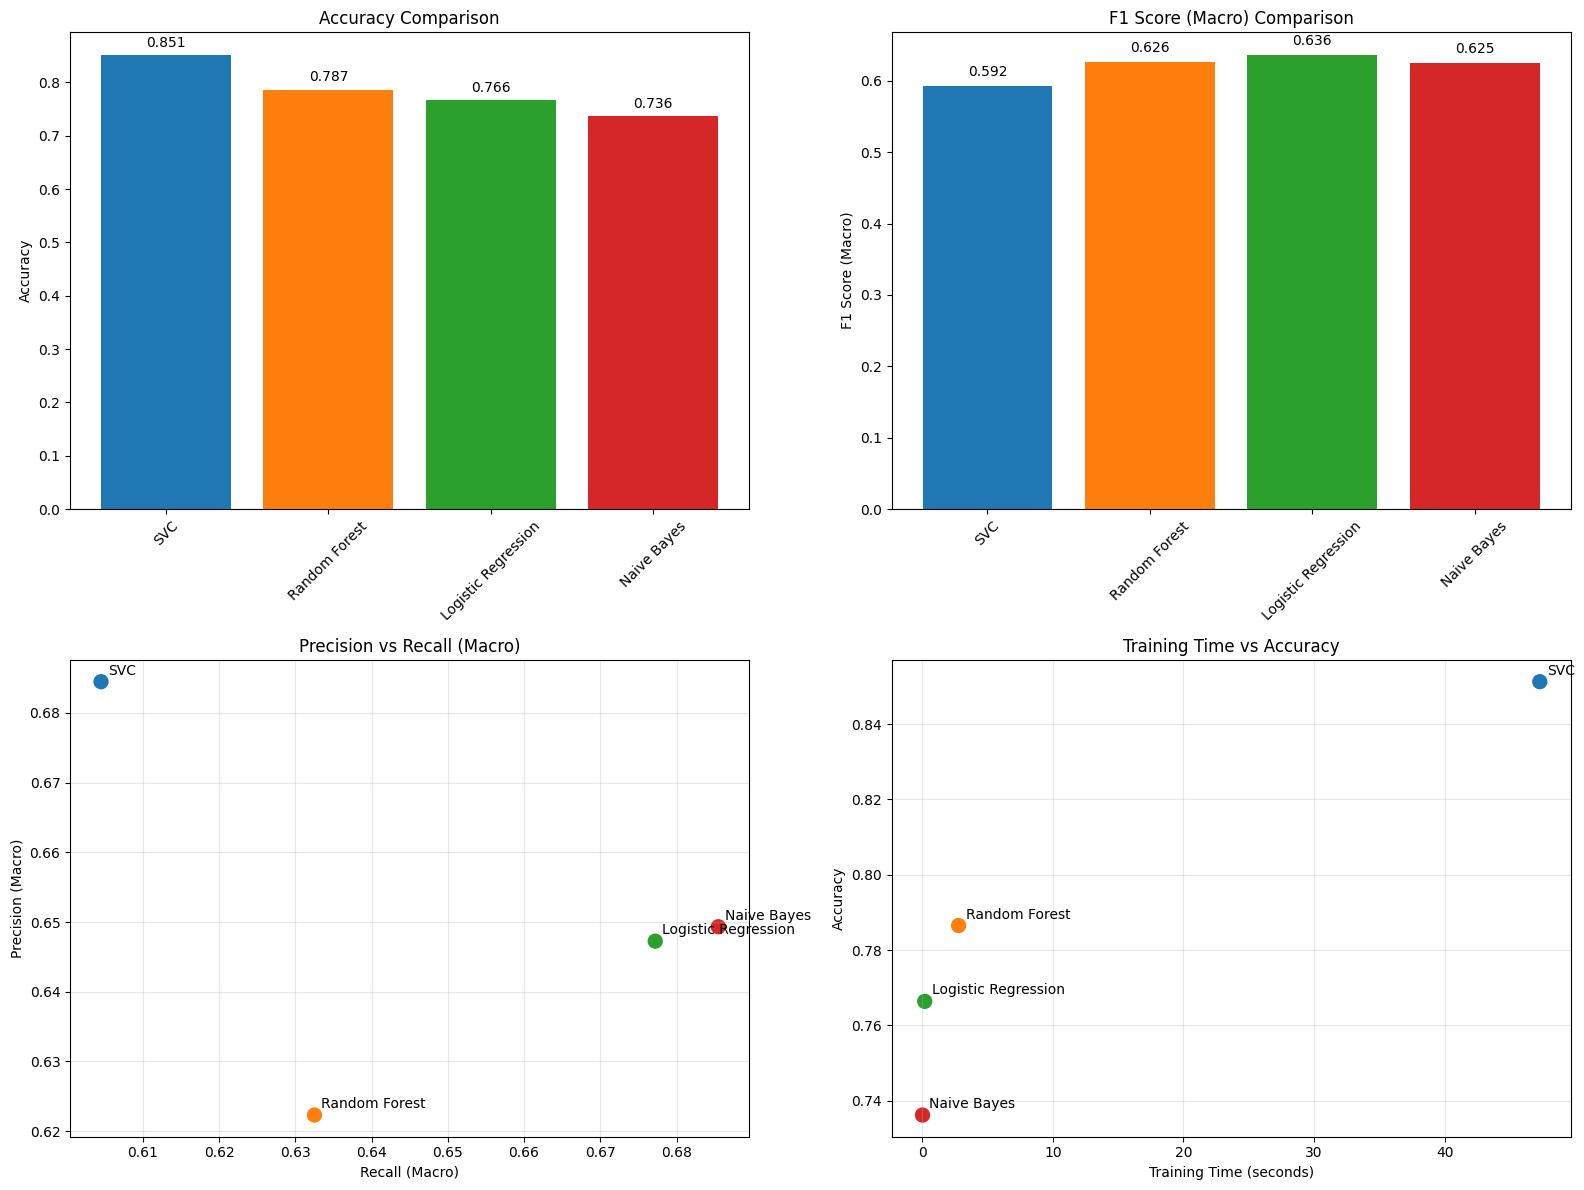

In [58]:
# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['Accuracy'],
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# F1 Macro comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['F1 (Macro)'],
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,1].set_title('F1 Score (Macro) Comparison')
axes[0,1].set_ylabel('F1 Score (Macro)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1 (Macro)']):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Precision vs Recall (Macro)
axes[1,0].scatter(comparison_df['Recall (Macro)'], comparison_df['Precision (Macro)'],
                  s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for i, model in enumerate(comparison_df['Model']):
    axes[1,0].annotate(model,
                       (comparison_df['Recall (Macro)'].iloc[i],
                        comparison_df['Precision (Macro)'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,0].set_xlabel('Recall (Macro)')
axes[1,0].set_ylabel('Precision (Macro)')
axes[1,0].set_title('Precision vs Recall (Macro)')
axes[1,0].grid(True, alpha=0.3)

# Training time vs Accuracy
axes[1,1].scatter(comparison_df['Training Time (s)'], comparison_df['Accuracy'],
                  s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for i, model in enumerate(comparison_df['Model']):
    axes[1,1].annotate(model,
                       (comparison_df['Training Time (s)'].iloc[i],
                        comparison_df['Accuracy'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,1].set_xlabel('Training Time (seconds)')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Training Time vs Accuracy')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['Accuracy'],
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# F1 Macro comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['F1 (Macro)'],
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,1].set_title('F1 Score (Macro) Comparison')
axes[0,1].set_ylabel('F1 Score (Macro)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1 (Macro)']):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Precision vs Recall (Macro)
axes[1,0].scatter(comparison_df['Recall (Macro)'], comparison_df['Precision (Macro)'],
                  s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for i, model in enumerate(comparison_df['Model']):
    axes[1,0].annotate(model,
                       (comparison_df['Recall (Macro)'].iloc[i],
                        comparison_df['Precision (Macro)'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,0].set_xlabel('Recall (Macro)')
axes[1,0].set_ylabel('Precision (Macro)')
axes[1,0].set_title('Precision vs Recall (Macro)')
axes[1,0].grid(True, alpha=0.3)

# Training time vs Accuracy
axes[1,1].scatter(comparison_df['Training Time (s)'], comparison_df['Accuracy'],
                  s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for i, model in enumerate(comparison_df['Model']):
    axes[1,1].annotate(model,
                       (comparison_df['Training Time (s)'].iloc[i],
                        comparison_df['Accuracy'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,1].set_xlabel('Training Time (seconds)')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Training Time vs Accuracy')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['Accuracy'],
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# F1 Macro comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['F1 (Macro)'],
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0,1].set_title('F1 Score (Macro) Comparison')
axes[0,1].set_ylabel('F1 Score (Macro)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['F1 (Macro)']):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Precision vs Recall (Macro)
axes[1,0].scatter(comparison_df['Recall (Macro)'], comparison_df['Precision (Macro)'],
                  s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for i, model in enumerate(comparison_df['Model']):
    axes[1,0].annotate(model,
                       (comparison_df['Recall (Macro)'].iloc[i],
                        comparison_df['Precision (Macro)'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,0].set_xlabel('Recall (Macro)')
axes[1,0].set_ylabel('Precision (Macro)')
axes[1,0].set_title('Precision vs Recall (Macro)')
axes[1,0].grid(True, alpha=0.3)

# Training time vs Accuracy
axes[1,1].scatter(comparison_df['Training Time (s)'], comparison_df['Accuracy'],
                  s=100, c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for i, model in enumerate(comparison_df['Model']):
    axes[1,1].annotate(model,
                       (comparison_df['Training Time (s)'].iloc[i],
                        comparison_df['Accuracy'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points')
axes[1,1].set_xlabel('Training Time (seconds)')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_title('Training Time vs Accuracy')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Ranking Summary

In [59]:
print("🏆 Best Models by Different Metrics:")
print(f"1. Highest Accuracy: {comparison_df.iloc[0]['Model']} ({comparison_df.iloc[0]['Accuracy']:.4f})")
print(f"2. Highest F1 (Macro): {comparison_df.sort_values('F1 (Macro)', ascending=False).iloc[0]['Model']} ({comparison_df.sort_values('F1 (Macro)', ascending=False).iloc[0]['F1 (Macro)']:.4f})")
print(f"3. Fastest Training: {comparison_df.sort_values('Training Time (s)').iloc[0]['Model']} ({comparison_df.sort_values('Training Time (s)').iloc[0]['Training Time (s)']:.1f}s)")

🏆 Best Models by Different Metrics:
1. Highest Accuracy: SVC (0.8513)
2. Highest F1 (Macro): Logistic Regression (0.6361)
3. Fastest Training: Naive Bayes (0.0s)


In [60]:
# Best balanced model (accuracy vs speed)
comparison_df['Efficiency'] = comparison_df['Accuracy'] / (comparison_df['Training Time (s)'] / 60)  # Accuracy per minute
best_balanced = comparison_df.sort_values('Efficiency', ascending=False).iloc[0]
print(f"4. Best Balanced (Accuracy/Speed): {best_balanced['Model']} (Efficiency: {best_balanced['Efficiency']:.4f})")


4. Best Balanced (Accuracy/Speed): Naive Bayes (Efficiency: 3976.3400)


In [61]:
best_model = comparison_df.iloc[0]['Model']
print(f"✅ **{best_model}** is the overall best model")
print(f"   - Highest accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"   - Good balance across all metrics")
print(f"   - Suitable for production if inference time is not critical")

✅ **SVC** is the overall best model
   - Highest accuracy: 0.8513
   - Good balance across all metrics
   - Suitable for production if inference time is not critical


## Voting Classifier

### Hard Voting

---

Implement hard voting ensemble that combines predictions from multiple models by taking the majority vote from class predictions. Each model provides one vote for the predicted class.

---

In [62]:
hard_start = datetime.now()
hard_voting_clf = VotingClassifier(
    estimators=[
        ('svc', models['SVC']),
        ('nb', models['Naive Bayes']),
        ('rf', models['Random Forest']),
        ('lr', models['Logistic Regression']),
    ],
    voting='hard',
)

In [63]:
# Training Hard Voting Classifier
print("Training Hard Voting Classifier...")
hard_voting_clf.fit(X_train_final, y_train_final)
hard_time = (datetime.now() - hard_start).total_seconds()
print("Hard Voting Classifier training finished!")

Training Hard Voting Classifier...
Hard Voting Classifier training finished!


In [64]:
hard_voting_pred = hard_voting_clf.predict(X_test)
hard_voting_accuracy = accuracy_score(y_test, hard_voting_pred)

In [65]:
models['Hard Voting'] = hard_voting_clf
results['Hard Voting'] = {
    'predictions': hard_voting_pred,
    'accuracy': hard_voting_accuracy,
    'precision': precision_recall_fscore_support(y_test, hard_voting_pred),
    'training_time': hard_time,
}

In [66]:
print("=== HARD VOTING CLASSIFIER RESULTS ===")
print(f"Hard Voting Accuracy: {hard_voting_accuracy:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, hard_voting_pred))

=== HARD VOTING CLASSIFIER RESULTS ===
Hard Voting Accuracy: 0.8218

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1499
           1       0.21      0.29      0.24       177
           2       0.93      0.83      0.88      1303

    accuracy                           0.82      2979
   macro avg       0.66      0.67      0.66      2979
weighted avg       0.84      0.82      0.83      2979



### Model SVC for Soft

---

Prepare Support Vector Classifier model with probability estimation for soft voting, optimizing parameters to produce accurate prediction probabilities.

---

In [67]:
svc_prob_start = datetime.now()
svc_model_prob = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    random_state=42,
    probability=True,
)

svc_model_prob.fit(X_train_final, y_train_final)
svc_prob_time = (datetime.now() - svc_prob_start).total_seconds()
svc_prob_pred = svc_model_prob.predict(X_test)

In [68]:
models['SVC Prob'] = svc_model_prob
results['SVC Prob'] = {
    'predictions': svc_model_prob,
    'accuracy': accuracy_score(y_test, svc_prob_pred),
    'precision': precision_recall_fscore_support(y_test, svc_prob_pred),
    'training_time': svc_prob_time,
}

In [69]:
print(f"  Accuracy: {results['SVC Prob']['accuracy']:.4f}")
print("Classification Report:")
print(classification_report(y_test, svc_prob_pred))

  Accuracy: 0.8513
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1499
           1       0.33      0.01      0.02       177
           2       0.90      0.85      0.88      1303

    accuracy                           0.85      2979
   macro avg       0.68      0.60      0.59      2979
weighted avg       0.83      0.85      0.83      2979



### Soft Voting

---

Implement soft voting ensemble that combines prediction probabilities from multiple models. This method typically provides better results as it considers the confidence level of each model.

---

In [70]:
soft_start = datetime.now()
soft_voting_clf = VotingClassifier(
    estimators=[
        ('svc', svc_model_prob),
        ('nb', models['Naive Bayes']),
        ('rf', models['Random Forest']),
        ('lr', models['Logistic Regression']),
    ],
    voting='soft',
)

In [71]:
# Training Soft Voting Classifier
print("Training Soft Voting Classifier...")
soft_voting_clf.fit(X_train_final, y_train_final)
soft_time = (datetime.now() - soft_start).total_seconds()
print("Soft Voting Classifier training selesai!")

Training Soft Voting Classifier...
Soft Voting Classifier training selesai!


In [72]:
soft_voting_pred = soft_voting_clf.predict(X_test)
soft_voting_accuracy = accuracy_score(y_test, soft_voting_pred)

In [73]:
models['Soft Voting'] = soft_voting_clf
results['Soft Voting'] = {
    'predictions': soft_voting_pred,
    'accuracy': soft_voting_accuracy,
    'precision': precision_recall_fscore_support(y_test, soft_voting_pred),
    'training_time': soft_time,
}

In [74]:
print("=== SOFT VOTING CLASSIFIER RESULTS ===")
print(f"Soft Voting Accuracy: {soft_voting_accuracy:.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, soft_voting_pred))

=== SOFT VOTING CLASSIFIER RESULTS ===
Soft Voting Accuracy: 0.8301

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1499
           1       0.20      0.20      0.20       177
           2       0.90      0.86      0.88      1303

    accuracy                           0.83      2979
   macro avg       0.65      0.65      0.65      2979
weighted avg       0.83      0.83      0.83      2979



## Compare All Accuracy

---

Conduct comprehensive accuracy comparison of all implemented approaches: individual models, hard voting, and soft voting. This analysis determines the best approach for deployment.

---

In [75]:
summary_data = []
for model_name, result in results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'][0],
        'Recall': result['precision'][1],
        'F1-Score': result['precision'][2],
        'Support': result['precision'][3],
        'Training Time (s)': result['training_time'],
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='Accuracy', ascending=False)

In [76]:
print("=== FINAL MODEL COMPARISON ===")
print(summary_df.to_string(index=False))
print()
print("Best Model:", summary_df.iloc[0]['Model'])
print("Best Accuracy:", summary_df.iloc[0]['Accuracy'])

=== FINAL MODEL COMPARISON ===
              Model  Accuracy                                                     Precision                                                         Recall                                                      F1-Score           Support  Training Time (s)
                SVC  0.851292  [0.8151549942594719, 0.3333333333333333, 0.9049553208773355] [0.9472981987991995, 0.011299435028248588, 0.8549501151189562] [0.8762727553224313, 0.02185792349726776, 0.8792423046566693] [1499, 177, 1303]          47.293125
           SVC Prob  0.851292  [0.8151549942594719, 0.3333333333333333, 0.9049553208773355] [0.9472981987991995, 0.011299435028248588, 0.8549501151189562] [0.8762727553224313, 0.02185792349726776, 0.8792423046566693] [1499, 177, 1303]         230.086271
        Soft Voting  0.830144  [0.8437299035369775, 0.1977401129943503, 0.9029671210906175]      [0.875250166777852, 0.1977401129943503, 0.86415963161934]  [0.8592010478061559, 0.1977401129943503, 0.88313725

### Visualization Model Comparison

---

Create final visualizations displaying performance comparisons of all models and ensemble methods in an easily understandable format, such as bar charts or radar charts for various evaluation metrics.

---

In [77]:
models = summary_df['Model'].tolist()
accuracies = summary_df['Accuracy'].tolist()

accuracies = [round(acc, 4) for acc in accuracies]

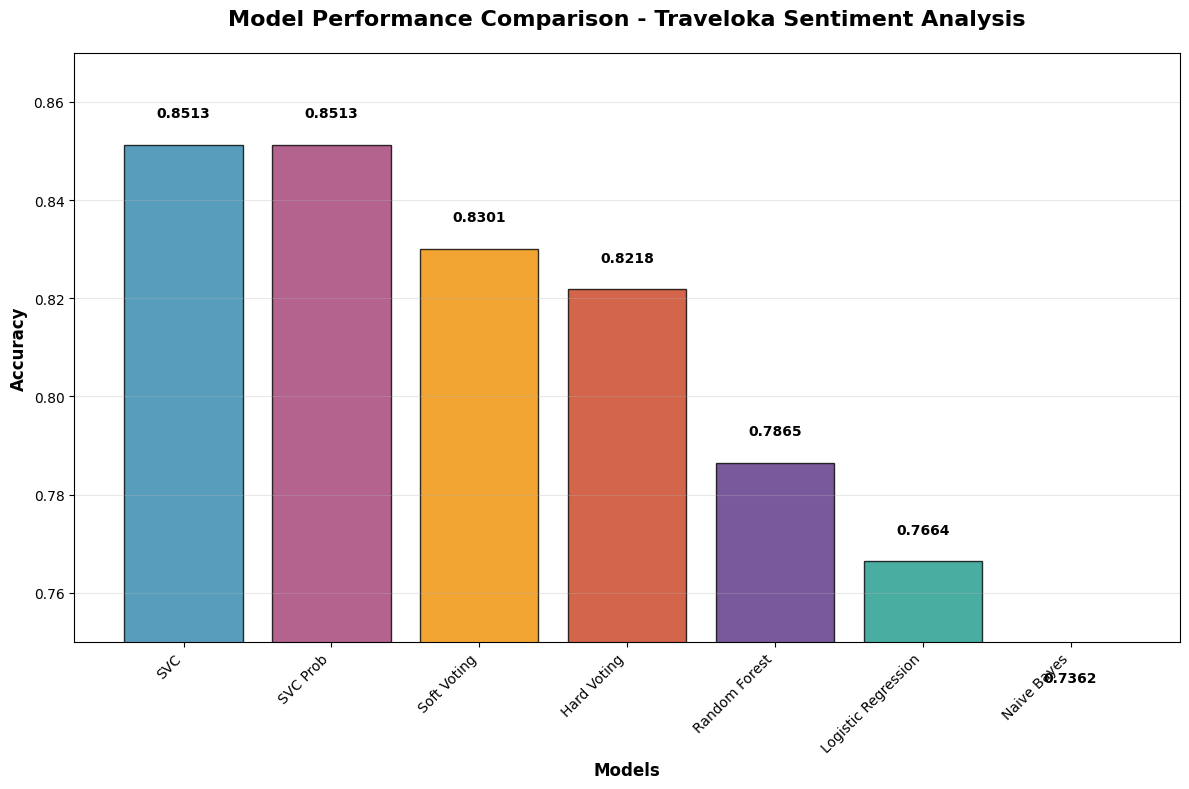

In [78]:
plt.figure(figsize=(12, 8))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592E83', '#1B998B']
bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

plt.title('Model Performance Comparison - Traveloka Sentiment Analysis',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Models', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.ylim(0.75, 0.87)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Hyperparameter Tunning for SVC Prob

---

Conduct comprehensive accuracy comparison of all implemented approaches: individual models, hard voting, and soft voting. This analysis determines the best approach for deployment.

---

In [99]:
param_grid = [
    # RBF kernel
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'class_weight': ['balanced', {0:1, 1:5, 2:1}, {0:1, 1:8, 2:1}]
    },
    # Linear kernel
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced', {0:1, 1:5, 2:1}, {0:1, 1:8, 2:1}]
    },
]

In [ ]:
svc_grid_start = datetime.now()
svc_grid = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

svc_grid.fit(X_train_final, y_train_final)
svc_grid_time = (datetime.now() - svc_grid_start).total_seconds()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
print("Tunning Finished:", svc_grid_time)
print("Best parameters:", svc_grid.best_params_)
print("Best cross-validation score:", svc_grid.best_score_)

## Inference

---
    
Implement inference functions to perform sentiment prediction on new data using the best selected model. This section includes a complete preprocessing pipeline from raw text to final prediction results.

---

In [79]:
import re
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

In [91]:
def predict_sentiment(review_text, svc_model, tfidf_vectorizer, label_encoder):
    # Preprocess the text
    cleaned_text = preprocess_text(review_text)

    # Transform text using the same TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])

    # Make prediction
    prediction = svc_model.predict(text_tfidf)[0]

    # Calculate confidence score based on the decision function
    decision_scores = svc_model.decision_function(text_tfidf)[0]

    # For multi-class classification, get the score of the predicted class
    if len(decision_scores.shape) > 1:  # If one-vs-rest (shape: [n_samples, n_classes])
        confidence_score = decision_scores[prediction]
    else:  # If one-vs-one (shape: [n_samples * (n_classes -1)/2])
        # For OVO, we need to normalize the scores
        confidence_score = np.max(decision_scores)

    # Convert to percentage using sigmoid
    confidence = 1 / (1 + np.exp(-np.abs(confidence_score))) * 100

    # Convert prediction to original label
    sentiment_label = label_encoder.inverse_transform([prediction])[0]

    return {
        'text': review_text,
        'predicted_sentiment': sentiment_label,
        'confidence': round(float(confidence), 1),
    }

In [95]:
def predict_sentiment_with_proba(review_text, svc_model, tfidf_vectorizer, label_encoder):

    # Preprocess the text
    cleaned_text = preprocess_text(review_text)

    # Transform text using the same TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])

    # Make prediction
    prediction = svc_model.predict(text_tfidf)[0]
    prediction_proba = svc_model.predict_proba(text_tfidf)[0]

    # Convert prediction back to original label
    sentiment_label = label_encoder.inverse_transform([prediction])[0]

    # Get confidence score
    confidence = max(prediction_proba) * 100

    return {
        'text': review_text,
        'predicted_sentiment': sentiment_label,
        'confidence': confidence,
        'probabilities': {
            'negative': prediction_proba[0] * 100,
            'neutral': prediction_proba[1] * 100,
            'positive': prediction_proba[2] * 100
        }
    }


In [92]:
sample_reviews = [
      "Aplikasi Traveloka sangat bagus dan mudah digunakan!",
      "Pelayanan buruk, aplikasi sering error dan lambat",
      "Aplikasi lumayan, tidak terlalu bagus tidak terlalu buruk",
      "Booking hotel mudah dan cepat, recommended!",
      "Aplikasi jelek banget, selalu crash"
  ]

In [96]:
print("📝 SAMPLE REVIEWS & PREDICTIONS:")
print()

for i, review in enumerate(sample_reviews, 1):
    result = predict_sentiment_with_proba(review, svc_model_prob, tfidf_vectorizer, label_encoder)

    print(f"{i}. Review: '{review}'")
    print(f"   Predicted: {result['predicted_sentiment']} ({result['confidence']:.1f}% confidence)")
    print(f"   Probabilities: Neg={result['probabilities']['negative']:.1f}%, "
          f"Neu={result['probabilities']['neutral']:.1f}%, "
          f"Pos={result['probabilities']['positive']:.1f}%")
    print()

📝 SAMPLE REVIEWS & PREDICTIONS:

1. Review: 'Aplikasi Traveloka sangat bagus dan mudah digunakan!'
   Predicted: positive (100.0% confidence)
   Probabilities: Neg=0.0%, Neu=0.0%, Pos=100.0%

2. Review: 'Pelayanan buruk, aplikasi sering error dan lambat'
   Predicted: negative (98.9% confidence)
   Probabilities: Neg=98.9%, Neu=0.7%, Pos=0.4%

3. Review: 'Aplikasi lumayan, tidak terlalu bagus tidak terlalu buruk'
   Predicted: positive (64.4% confidence)
   Probabilities: Neg=35.2%, Neu=0.4%, Pos=64.4%

4. Review: 'Booking hotel mudah dan cepat, recommended!'
   Predicted: positive (98.5% confidence)
   Probabilities: Neg=1.5%, Neu=0.1%, Pos=98.5%

5. Review: 'Aplikasi jelek banget, selalu crash'
   Predicted: negative (86.9% confidence)
   Probabilities: Neg=86.9%, Neu=0.0%, Pos=13.1%



In [ ]:
# Save TF-IDF vectorizer
# joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# print("✅ TF-IDF Vectorizer saved: tfidf_vectorizer.pkl")

In [ ]:
# Save label encoder
# joblib.dump(label_encoder, 'label_encoder.pkl')
# print("✅ Label Encoder saved: label_encoder.pkl")